# [POC] Labour Progression Regression w PyTorch Neural Network

This dataset contains **2126** records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

1. Normal
2. Suspect
3. Pathological

The dataset is obtained from [Kaggle.com](https://www.kaggle.com/), an online machine learning community.

Link to the dataset is [Here](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification?resource=download)

## **1. Importing Packages**

In [29]:
# General Python imports
import os
import gc
import time
import tqdm
import random

import numpy as np
import pandas as pd

# Visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt  

# Machine Learning libraries
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import nn
from torch.optim import Adam
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [30]:
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        if filename == "fetal_health_labour_progression.csv":
            FILE_PATH = os.path.join(dirname, filename)
            print(FILE_PATH)

input/fetal_health_labour_progression.csv


## **2. Config**

In [31]:
RANDOM = random.randint(0, 100)

TEST_SIZE = 0.20
VAL_SIZE = 0.15

EPOCHS = 100
BATCH_SIZE = 4
LR = 1e-3

## **3. Data**

### 3.1 Loading the Data

In [32]:
data = pd.read_csv(FILE_PATH)
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health,labour_progression
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0,-0.263971
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0,1.954455
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0,1.971483
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0,2.222054
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0,1.785438


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 23 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [34]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,1.333039e+02,9.840844,106.000000,126.000000,133.000000,140.000000,160.000000
accelerations,2126.0,3.178269e-03,0.003866,0.000000,0.000000,0.002000,0.006000,0.019000
fetal_movement,2126.0,9.480715e-03,0.046666,0.000000,0.000000,0.000000,0.003000,0.481000
uterine_contractions,2126.0,4.366416e-03,0.002946,0.000000,0.002000,0.004000,0.007000,0.015000
light_decelerations,2126.0,1.889464e-03,0.002960,0.000000,0.000000,0.000000,0.003000,0.015000
severe_decelerations,2126.0,3.292568e-06,0.000057,0.000000,0.000000,0.000000,0.000000,0.001000
prolongued_decelerations,2126.0,1.585136e-04,0.000590,0.000000,0.000000,0.000000,0.000000,0.005000
abnormal_short_term_variability,2126.0,4.699012e+01,17.192814,12.000000,32.000000,49.000000,61.000000,87.000000
mean_value_of_short_term_variability,2126.0,1.332785e+00,0.883241,0.200000,0.700000,1.200000,1.700000,7.000000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660e+00,18.396880,0.000000,0.000000,0.000000,11.000000,91.000000


### 3.2 Data Analysis

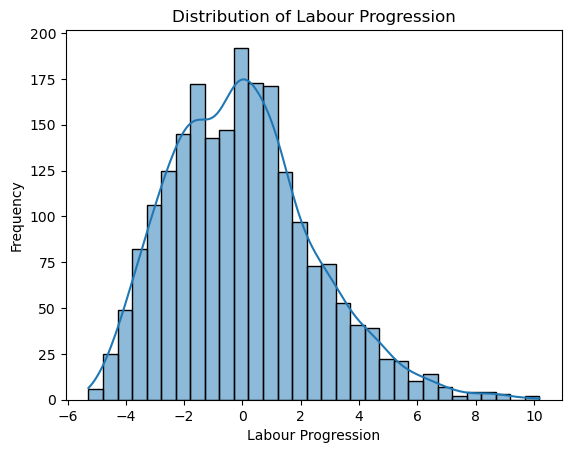

In [35]:
sns.histplot(data['labour_progression'], kde=True)  # histplot for distribution
plt.title('Distribution of Labour Progression')
plt.xlabel('Labour Progression')
plt.ylabel('Frequency')
plt.show()

The count plot of targets indicates an imbalance in data. This is a case that tends to provide misleading compute accuracy.


<Axes: >

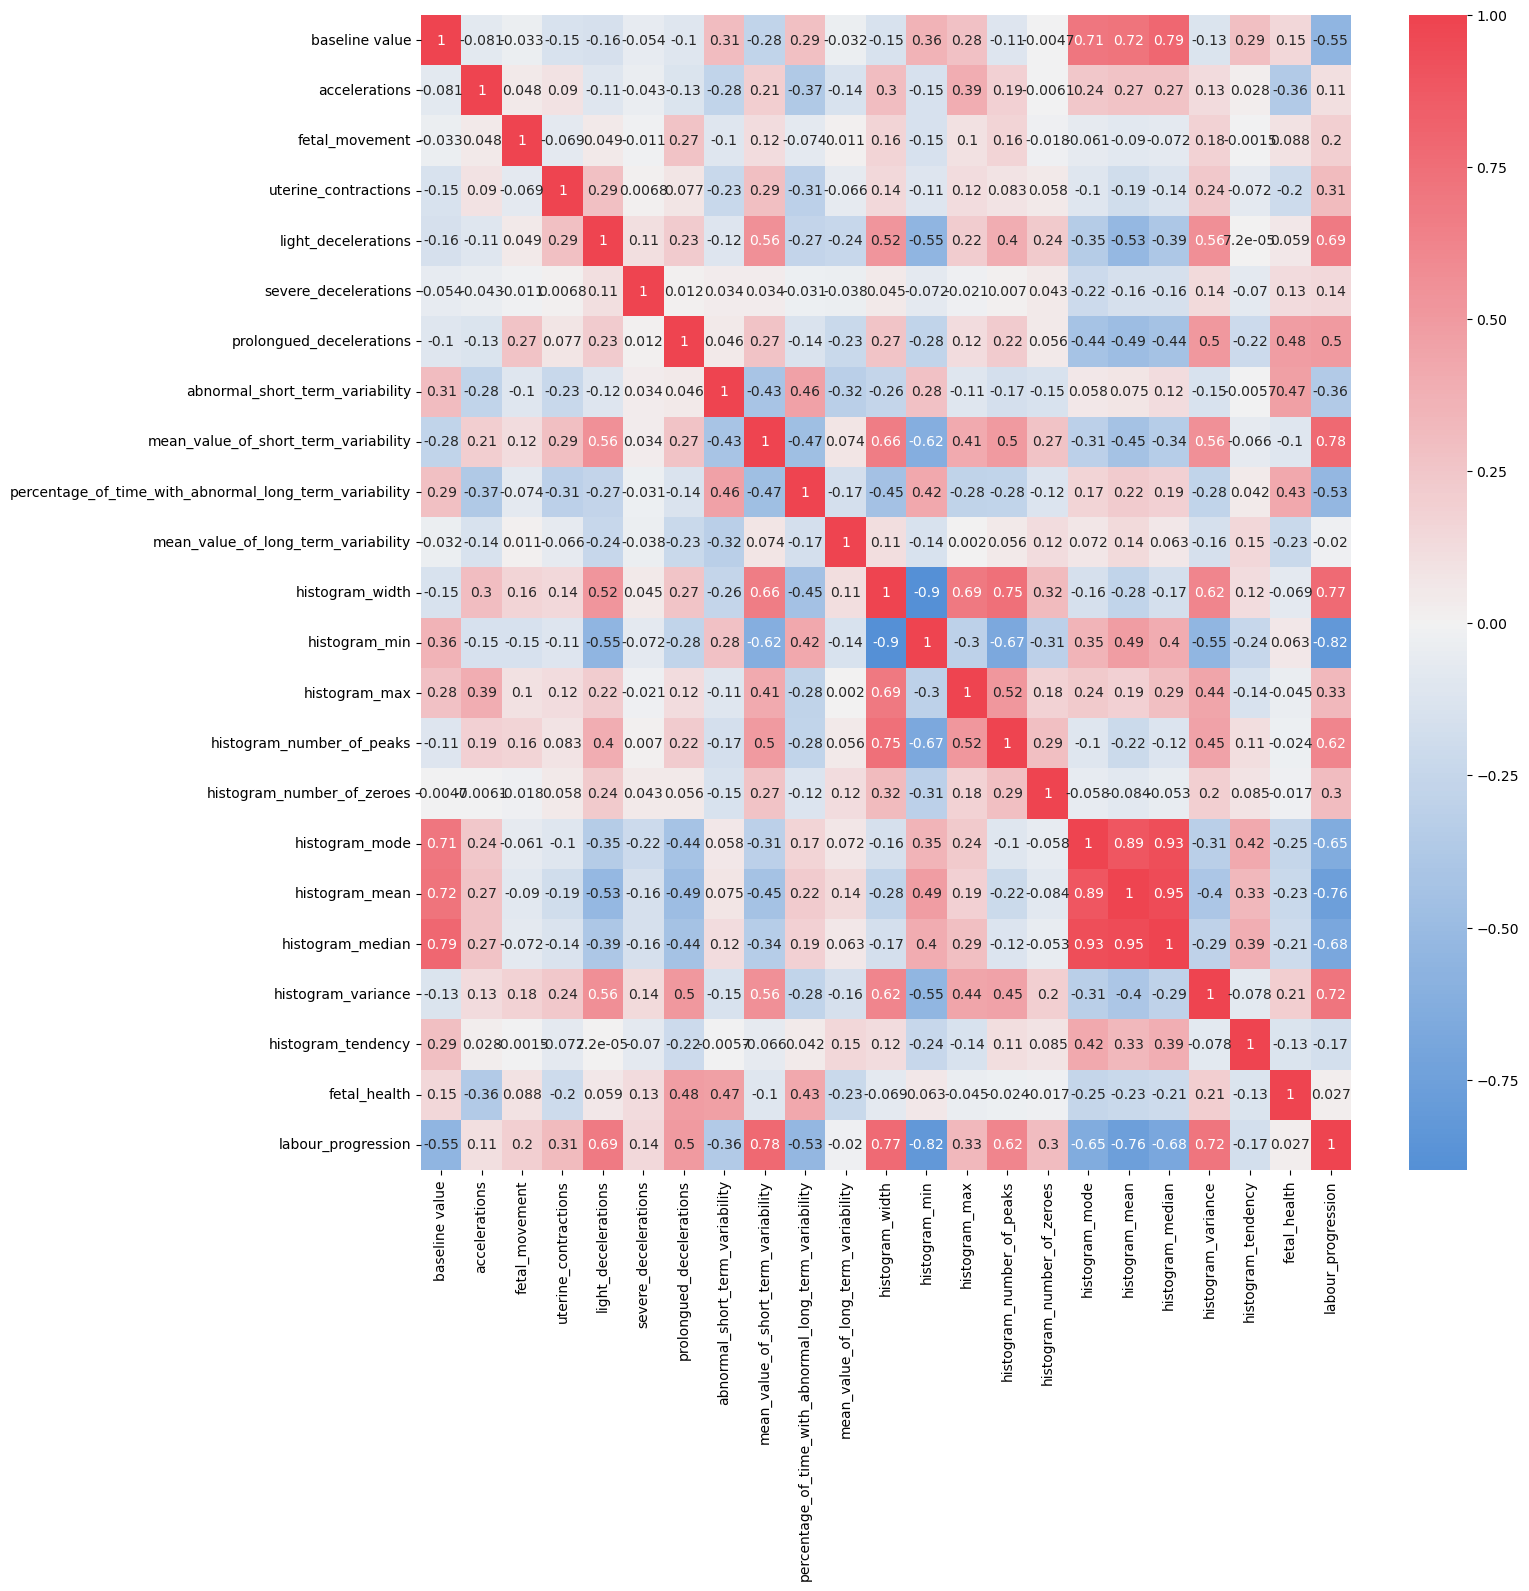

In [36]:
# Correlation matrix
corrmat= data.corr()
plt.figure(figsize=(15,15))  

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)

sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

Based on the correlation matix, we can infer that
1. light_deceleration
2. prolonged_deceleration
3. mean_value_of_short_term_variability
4. histogram_number_of_peaks
5. histogram_variance


are the features with higher correlation with labour progression.

### 3.3 Correlation with Labour Progression

**1. Light Deceleration**

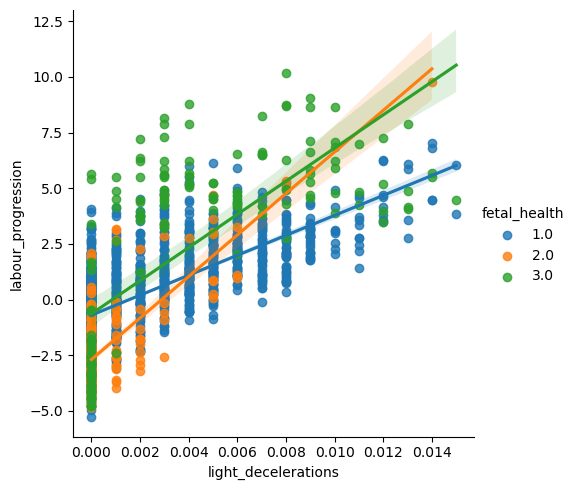

In [37]:
sns.lmplot(data=data, x="light_decelerations", y="labour_progression", hue="fetal_health")
plt.show()

**2. Prolonged Decelerations**

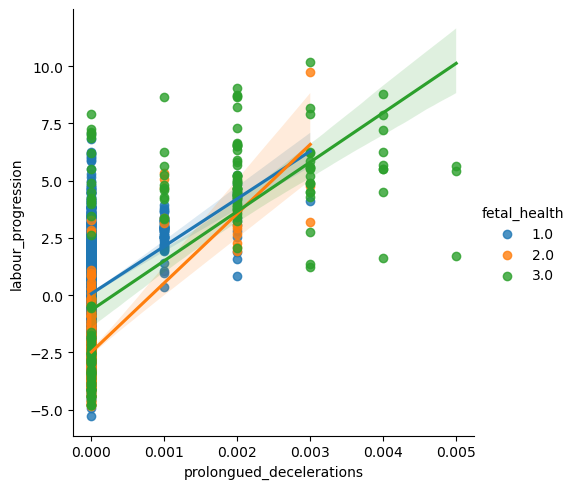

In [38]:
sns.lmplot(data=data, x="prolongued_decelerations", y="labour_progression", hue="fetal_health")
plt.show()

**3. Mean Value of Short Term Variability**

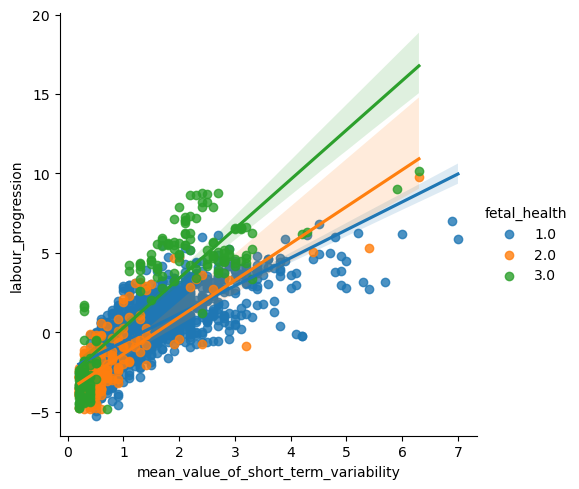

In [39]:
sns.lmplot(data=data, x="mean_value_of_short_term_variability", y="labour_progression", hue="fetal_health")
plt.show()

**4. Histogram: Number of Peaks**

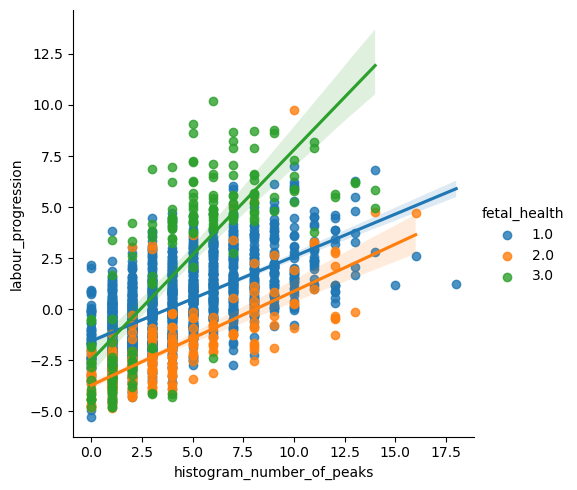

In [40]:
sns.lmplot(data=data, x="histogram_number_of_peaks", y="labour_progression", hue="fetal_health")
plt.show()

**5. Histogram Variance**

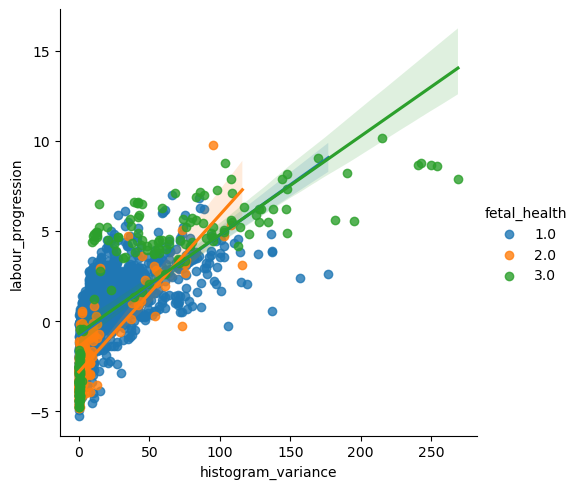

In [41]:
sns.lmplot(data=data, x="histogram_variance", y="labour_progression", hue="fetal_health")
plt.show()

### 3.5 Feature Scaling

We can clearly spot some outliers in our dataset. However, it is not quite a good idea to remove them yet as it may lead to overfitting. Though we may end up with better statistics.

A basic rule of thumb for the outliers in question is:
* It is a measurement error or data entry error, correct the error if possible. If you can’t fix it, remove that observation. In our case, this is the outcome of a CTG report so it is unlikely that this was a data entry error.
* If it is not a part of the population you are studying, you can legitimately remove the outlier. In this case, this all is about the fetus, and experts tag the classification. Let's stick with the expert opinion.

Thus assuming that these are the natural part of the population we are studying, we should not remove it.

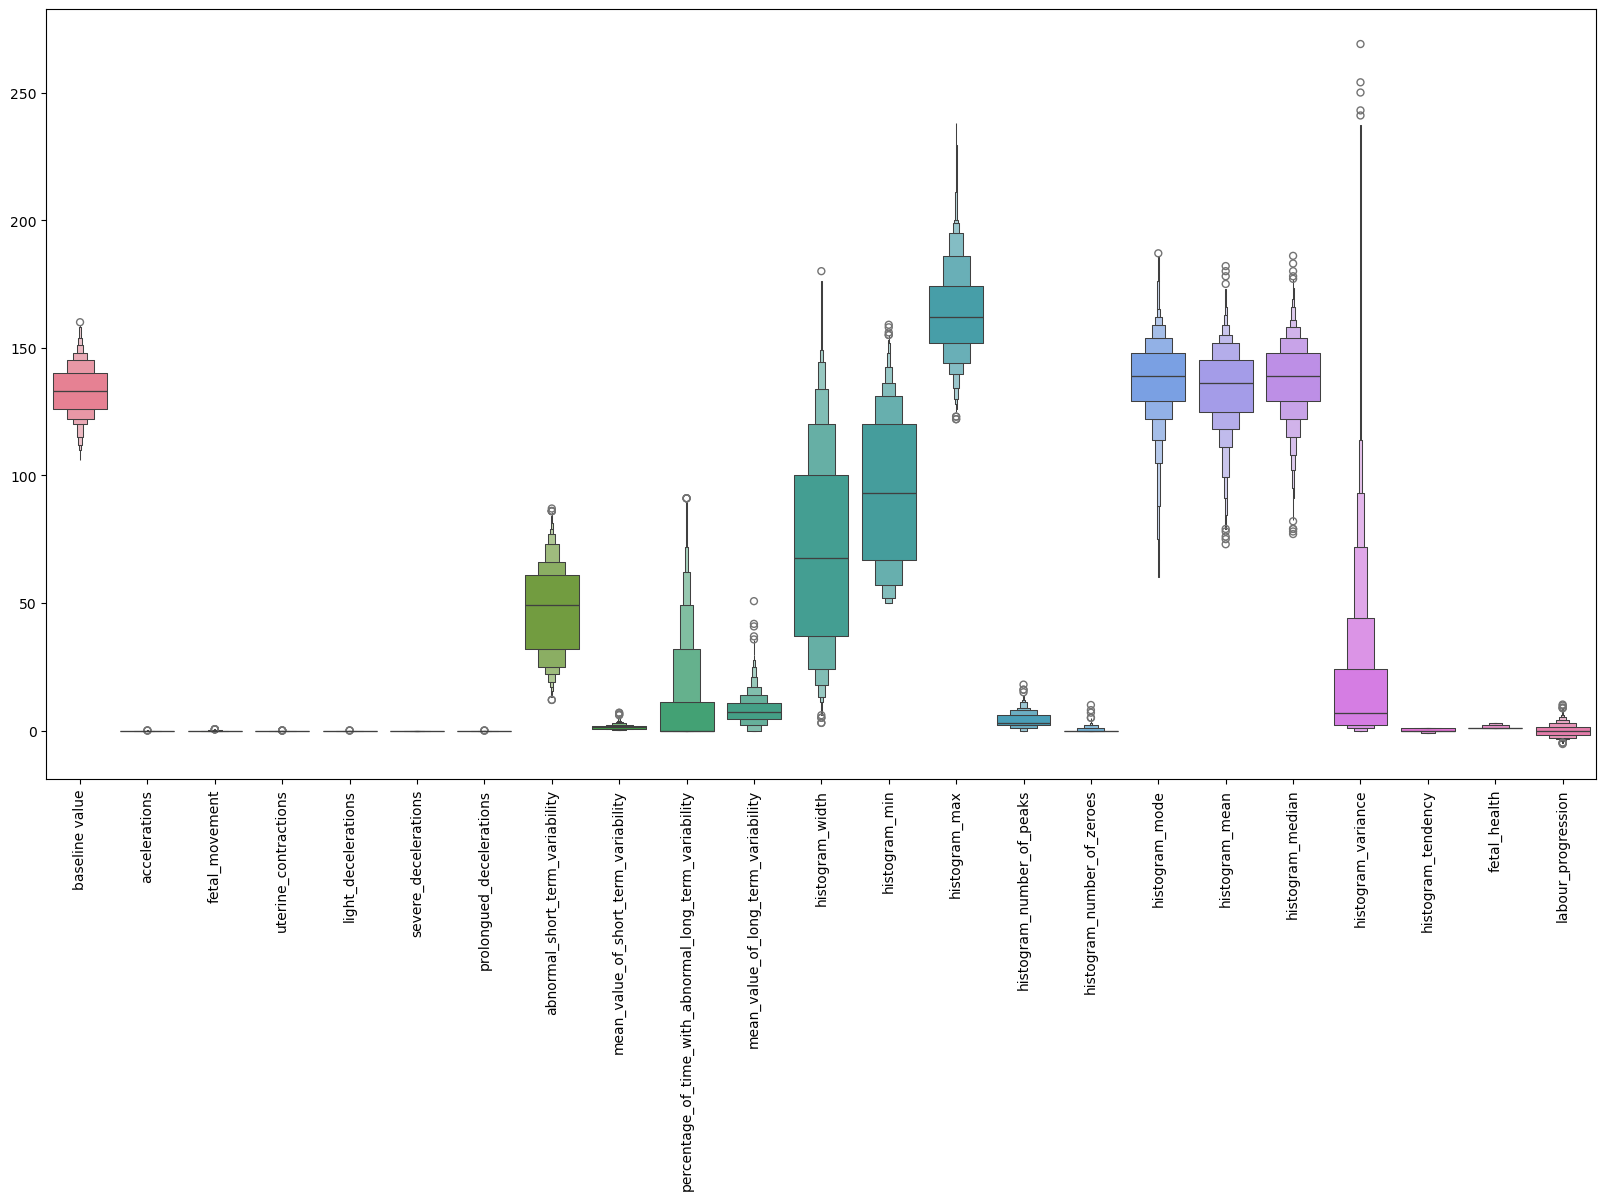

In [42]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = data)
plt.xticks(rotation=90)
plt.show()

The above plot shows the range of our feature attributes.

All the features are in different ranges. To fit this in a model we must scale it to the same range. -> StandardScaler

In [43]:
X = data.drop(["labour_progression", "fetal_health"],axis=1)
y = data["labour_progression"]

#Set up a standard scaler for the features
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)   
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,1.069490e-15,1.000235,-2.775197,-0.742373,-0.030884,0.680604,2.713428
accelerations,2126.0,-4.010589e-17,1.000235,-0.822388,-0.822388,-0.304881,0.730133,4.093929
fetal_movement,2126.0,-1.336863e-17,1.000235,-0.203210,-0.203210,-0.203210,-0.138908,10.106540
uterine_contractions,2126.0,-1.336863e-16,1.000235,-1.482465,-0.803434,-0.124404,0.894142,3.610264
light_decelerations,2126.0,-5.347452e-17,1.000235,-0.638438,-0.638438,-0.638438,0.375243,4.429965
severe_decelerations,2126.0,6.684315e-18,1.000235,-0.057476,-0.057476,-0.057476,-0.057476,17.398686
prolongued_decelerations,2126.0,1.336863e-17,1.000235,-0.268754,-0.268754,-0.268754,-0.268754,8.208570
abnormal_short_term_variability,2126.0,-7.352747e-17,1.000235,-2.035639,-0.872088,0.116930,0.815060,2.327675
mean_value_of_short_term_variability,2126.0,6.684315e-17,1.000235,-1.282833,-0.716603,-0.150373,0.415857,6.417893
percentage_of_time_with_abnormal_long_term_variability,2126.0,-5.347452e-17,1.000235,-0.535361,-0.535361,-0.535361,0.062707,4.412293


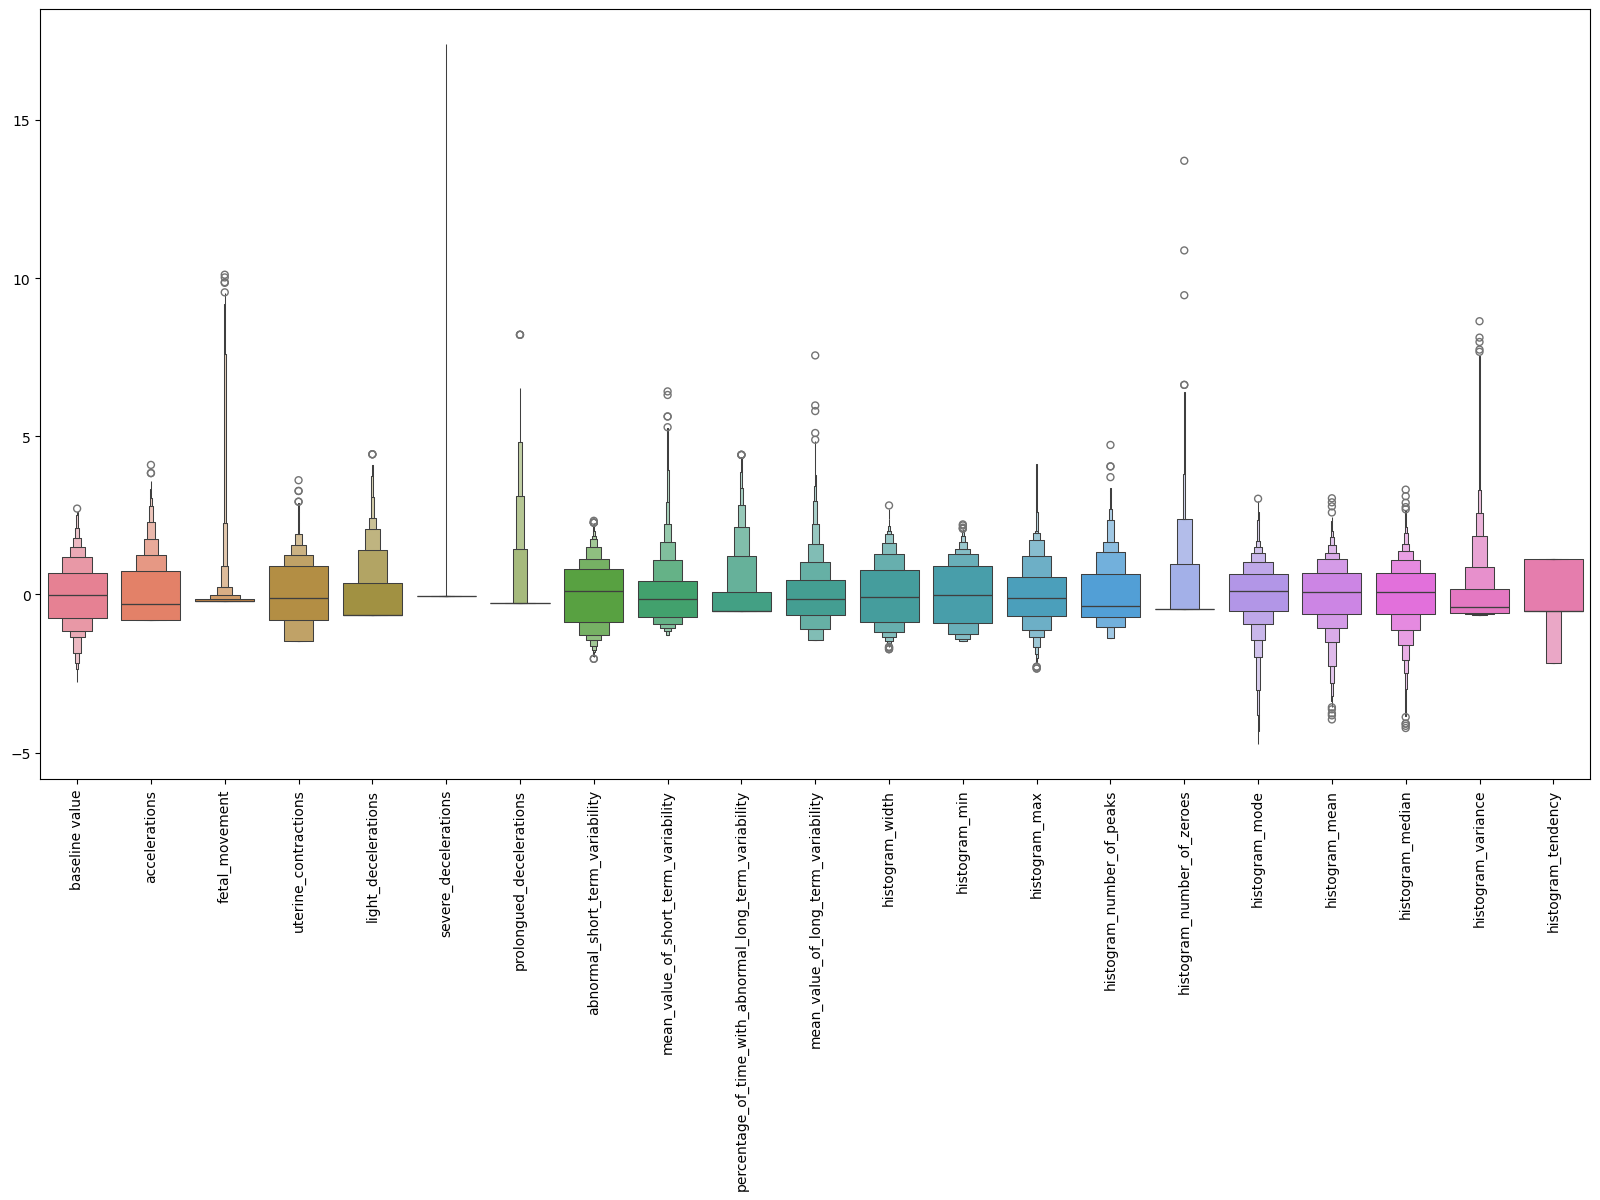

In [44]:
# Display scaled features
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_df)
plt.xticks(rotation=90)
plt.show()

## **4. Model**

### 4.1 Model Selection & Building

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM)

In [46]:
# Convert into tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [47]:
# Create TensorDatasets and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
test_dataset = TensorDataset(X_test_tensor, y_test_tensor.view(-1, 1))

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [48]:
# Model Definition
class LPRegressionNN(nn.Module):
    def __init__(self, num_features):
        super(LPRegressionNN, self).__init__()
        self.layer_1 = nn.Linear(num_features, 50)
        self.layer_2 = nn.Linear(50, 20)
        self.output_layer = nn.Linear(20, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer_1(x))
        x = torch.relu(self.layer_2(x))
        x = self.output_layer(x)
        return x
    
# Instantiate the model
num_features = X_train_tensor.shape[1]
model = LPRegressionNN(num_features)

# Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=LR)

In [49]:
# Training Loop
num_epochs = 1000
train_losses = []

model.train()
for epoch in range(1, num_epochs + 1):
    epoch_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    train_losses.append(np.mean(epoch_losses))
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

Epoch 100/1000, Loss: 0.24884693324565887
Epoch 200/1000, Loss: 0.1877368837594986
Epoch 300/1000, Loss: 0.10737645626068115
Epoch 400/1000, Loss: 0.05674165487289429
Epoch 500/1000, Loss: 0.04976116865873337
Epoch 600/1000, Loss: 0.053287822753190994
Epoch 700/1000, Loss: 0.03132232651114464
Epoch 800/1000, Loss: 0.020673997700214386
Epoch 900/1000, Loss: 0.018674908205866814
Epoch 1000/1000, Loss: 0.022933680564165115


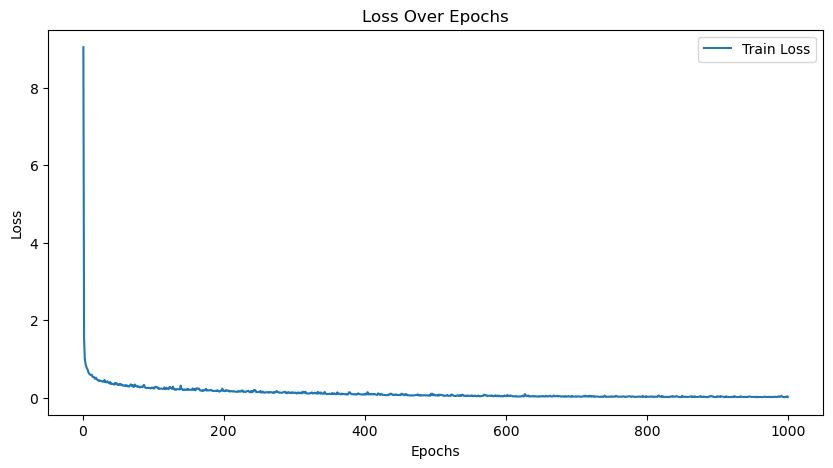

In [50]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [51]:
# Evaluate the model
model.eval()
test_loss = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()  # Sum up batch loss

test_loss /= len(test_loader.dataset)
print(f'Average loss on test set: {test_loss}')

Average loss on test set: 0.0005222735576716388


## **5. Demo**

### 5.1 Individual Feature Demo

In [52]:
row = random.randint(0, len(X_test) - 1)
X_demo = X_test.iloc[row, :]
y_demo = y_test.iloc[row]
print(f"Demo Features: {X_demo}\n")
print(f"Actual Target: {y_demo}")

Demo Features: baseline value                                            122.000
accelerations                                               0.002
fetal_movement                                              0.000
uterine_contractions                                        0.009
light_decelerations                                         0.009
severe_decelerations                                        0.000
prolongued_decelerations                                    0.000
abnormal_short_term_variability                            16.000
mean_value_of_short_term_variability                        3.500
percentage_of_time_with_abnormal_long_term_variability      0.000
mean_value_of_long_term_variability                        23.100
histogram_width                                            98.000
histogram_min                                              60.000
histogram_max                                             158.000
histogram_number_of_peaks                                   5

In [58]:
X_demo_np = X_demo.to_numpy().reshape(1, -1)
y_demo_np = np.array([[y_demo]])

# Convert to PyTorch tensors
X_demo_tensor = torch.from_numpy(X_demo_np).float()
y_demo_tensor = torch.from_numpy(y_demo_np).float()

with torch.no_grad():
    predicted_progression = model(X_demo_tensor)
    
predicted_progression_np = predicted_progression.numpy()
    
print(f"Predicted Labour Progression: {predicted_progression_np[0][0]}")
print(f"Actual Labour Progression: {y_demo}")

Predicted Labour Progression: 4.136507034301758
Actual Labour Progression: 4.257256860544671


### 5.2 Prediction Error Plot

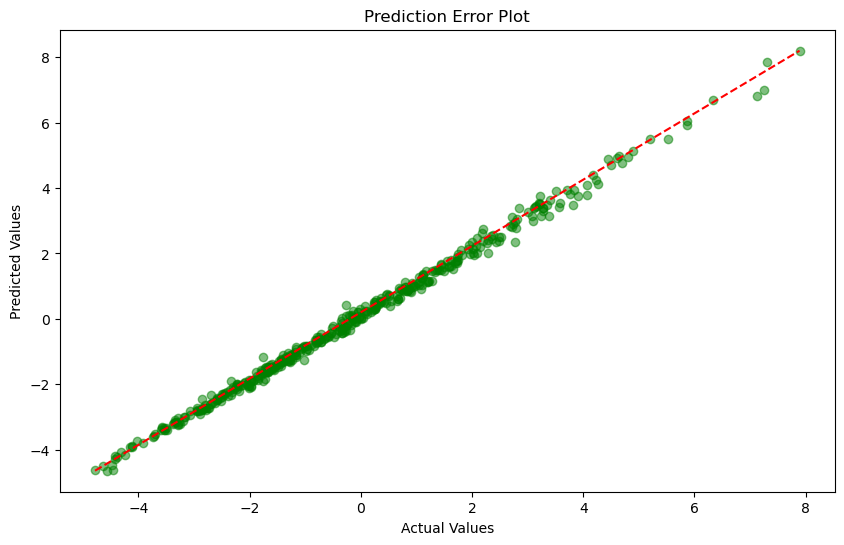

In [55]:
model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predictions.extend(output.view(-1).numpy())
        actuals.extend(target.view(-1).numpy())
        
predictions = np.array(predictions)
actuals = np.array(actuals)

plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, color="g", alpha=0.5)
plt.plot([actuals.min(), actuals.max()], [predictions.min(), predictions.max()], '--r')
plt.title('Prediction Error Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()